# Forgetting Heatmap 시각화

이 노트북은 continual learning 실험 결과를 forgetting heatmap으로 시각화합니다.
accuracy 값들을 직접 입력하여 커스텀 heatmap을 생성할 수 있습니다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import sys
from pathlib import Path

# 프로젝트 루트 경로 추가
PROJECT_ROOT = Path().resolve()
sys.path.insert(0, str(PROJECT_ROOT))

# 한글 폰트 및 스타일 설정
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['grid.alpha'] = 0.3


## 1. 데이터 입력

아래 셀에서 도메인 이름과 accuracy 행렬을 직접 입력하세요.

**형식:**
- `domain_names`: 도메인 이름 리스트 (예: ['600RPM', '800RPM', ...])
- `accuracy_matrix`: 2D 리스트 또는 numpy 배열
  - 각 행은 학습 단계 (D1, D2, ..., D6)
  - 각 열은 테스트 도메인
  - 값은 퍼센트 (0-100) 또는 소수 (0-1)
  - 아직 학습하지 않은 도메인은 `None` 또는 `np.nan`


In [2]:
# ===== 여기에 데이터 입력 =====

# 도메인 이름
domain_names = [
    "600RPM",
    "800RPM",
    "1000RPM",
    "1200RPM",
    "1400RPM",
    "1600RPM"
]

# Accuracy 행렬 (퍼센트 값, None은 아직 학습하지 않은 도메인)
# 형식: [행1, 행2, ..., 행6]
# 각 행은 [도메인1_정확도, 도메인2_정확도, ..., 도메인6_정확도]
accuracy_matrix_input = [
    [100.0, None, None, None, None, None],  # D1 학습 후
    [100.0, 100.0, None, None, None, None],  # D2 학습 후
    [77.16, 71.51, 100.0, None, None, None],  # D3 학습 후
    [48.59, 55.26, 60.05, 100.0, None, None],  # D4 학습 후
    [55.69, 56.89, 66.21, 71.77, 100.0, None],  # D5 학습 후
    [69.46, 67.58, 71.09, 48.76, 98.97, 100.0]  # D6 학습 후
]

# 시나리오 이름
scenario_name = "UOS_1DCNN_Baseline"

# 저장 파일명 (선택사항)
save_name = "forgetting_heatmap"

# 저장 디렉토리 (선택사항, None이면 현재 디렉토리)
output_dir = None  # 또는 "results/custom" 같은 경로


## 2. 데이터 전처리

입력된 데이터를 numpy 배열로 변환하고 정규화합니다.


In [3]:
# 입력 행렬을 numpy 배열로 변환
n_domains = len(domain_names)
accuracy_matrix = np.full((n_domains, n_domains), np.nan)

for i, row in enumerate(accuracy_matrix_input):
    for j, val in enumerate(row):
        if val is not None and not np.isnan(val):
            # 퍼센트 값인지 소수 값인지 자동 감지 (100보다 크면 퍼센트로 간주)
            if val > 1.0:
                accuracy_matrix[i, j] = val / 100.0  # 퍼센트 → 소수
            else:
                accuracy_matrix[i, j] = val  # 이미 소수

print(f"✅ 데이터 변환 완료: {n_domains}x{n_domains} 행렬")
print(f"   유효한 값 개수: {np.sum(~np.isnan(accuracy_matrix))}")


✅ 데이터 변환 완료: 6x6 행렬
   유효한 값 개수: 21


## 3. Heatmap 생성

Forgetting heatmap을 생성합니다. 각 행의 평균 정확도도 함께 표시됩니다.


In [4]:
# 각 행의 평균 계산 (Average Accuracy per Stage)
row_averages = []
for i in range(n_domains):
    row_values = accuracy_matrix[i, :]
    valid_values = row_values[~np.isnan(row_values)]
    if len(valid_values) > 0:
        row_avg = np.mean(valid_values)
        row_averages.append(row_avg)
    else:
        row_averages.append(np.nan)

print("\n📊 Stage별 평균 정확도:")
for i, avg in enumerate(row_averages):
    if not np.isnan(avg):
        print(f"   D{i+1}: {avg*100:.2f}%")
    else:
        print(f"   D{i+1}: N/A")



📊 Stage별 평균 정확도:
   D1: 100.00%
   D2: 100.00%
   D3: 82.89%
   D4: 65.97%
   D5: 70.11%
   D6: 75.98%


/tmp/ipykernel_2582110/4035757547.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])



✅ Heatmap 저장 완료: forgetting_heatmap_UOS_1DCNN_Baseline.png


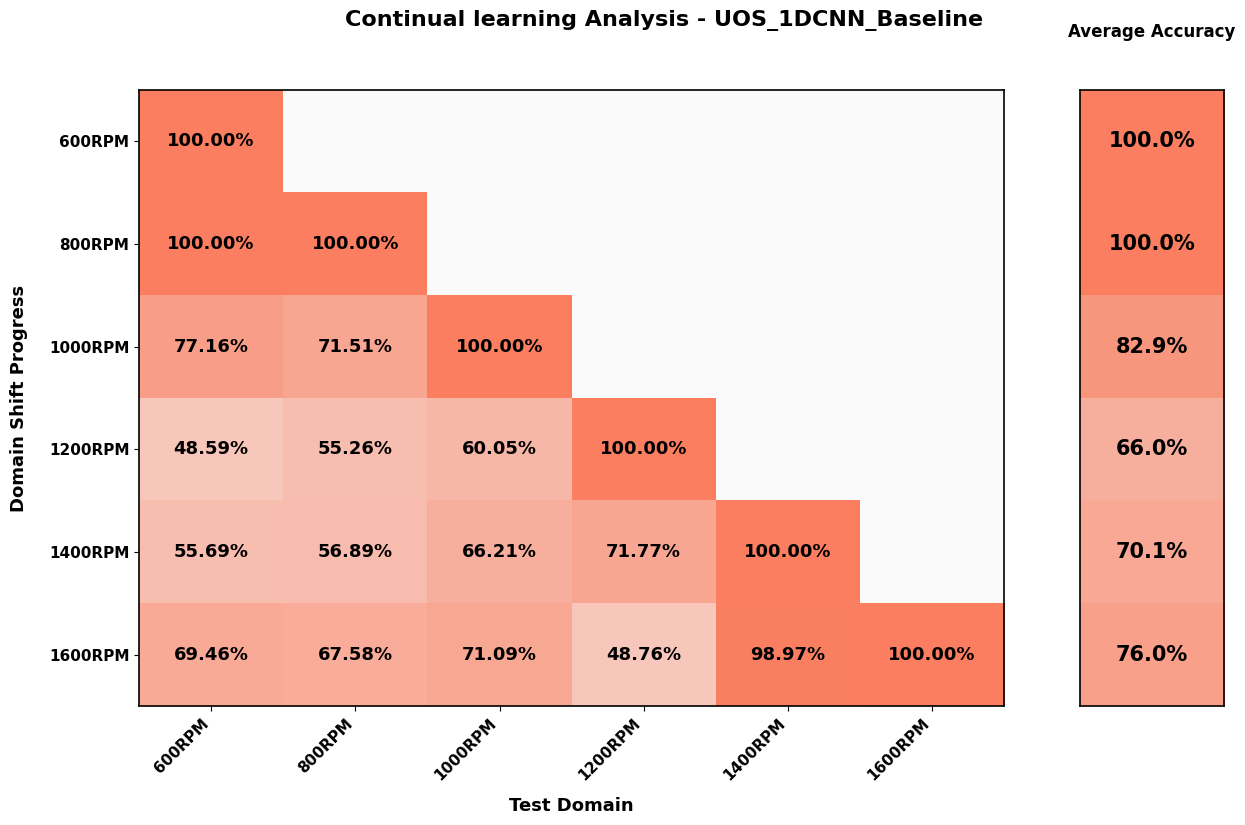

In [5]:
# Figure 생성
fig = plt.figure(figsize=(14, 8))

# GridSpec으로 메인 heatmap과 평균 열 분리
gs = gridspec.GridSpec(1, 2, width_ratios=[n_domains, 1], wspace=0.15)

ax_main = fig.add_subplot(gs[0])  # 메인 heatmap
ax_avg = fig.add_subplot(gs[1])   # 평균 열

# 커스텀 컬러맵 (흰색 → 연한 주황 → 주황)
cmap_custom = LinearSegmentedColormap.from_list(
    'white_to_lightgreen',
    ['#ffffff', '#f7c6ba', '#fa7e5f']
)

# 메인 Heatmap 생성
accuracy_matrix_percent = accuracy_matrix * 100
im_main = ax_main.imshow(accuracy_matrix_percent, cmap=cmap_custom, aspect='auto',
                        vmin=0, vmax=100, interpolation='nearest')

# 메인 heatmap 축 설정
ax_main.set_xticks(np.arange(n_domains))
ax_main.set_yticks(np.arange(n_domains))
ax_main.set_xticklabels(domain_names, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax_main.set_yticklabels(domain_names, rotation=0, ha='right', fontsize=11, fontweight='bold')

ax_main.set_xlabel('Test Domain', fontsize=13, fontweight='bold', labelpad=10)
ax_main.set_ylabel('Domain Shift Progress', fontsize=13, fontweight='bold', labelpad=15)

# 메인 heatmap 셀 값 표시
for i in range(n_domains):
    for j in range(n_domains):
        if not np.isnan(accuracy_matrix[i, j]):
            percent_val = accuracy_matrix[i, j] * 100
            ax_main.text(j, i, f'{percent_val:.2f}%',
                       ha='center', va='center', color='black',
                       fontsize=13, fontweight='bold')

# Stage Average 열 생성
row_avg_matrix = np.array(row_averages).reshape(-1, 1)
row_avg_percent = row_avg_matrix * 100
im_avg = ax_avg.imshow(row_avg_percent, cmap=cmap_custom, aspect='auto',
                      vmin=0, vmax=100, interpolation='nearest')

# 평균 열 축 설정
ax_avg.set_xticks([])
ax_avg.set_yticks([])
ax_avg.set_xlabel('')

# 평균 열 제목 추가
ax_avg.text(0.5, 1.08, 'Average Accuracy', 
           ha='center', va='bottom', fontsize=12, fontweight='bold',
           transform=ax_avg.transAxes)

# 평균 열 값 표시
for i in range(n_domains):
    if not np.isnan(row_averages[i]):
        percent_val = row_averages[i] * 100
        ax_avg.text(0, i, f'{percent_val:.1f}%',
                  ha='center', va='center', color='black',
                  fontsize=15, fontweight='bold')

# 전체 타이틀
fig.suptitle(f'Continual learning Analysis - {scenario_name}',
            fontsize=16, fontweight='bold', y=0.98)

# 배경색
ax_main.set_facecolor('#FAFAFA')
ax_avg.set_facecolor('#FAFAFA')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 저장
if output_dir is None:
    output_dir = Path('.')
else:
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

save_path = output_dir / f"{save_name}_{scenario_name}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✅ Heatmap 저장 완료: {save_path}")

plt.show()


---

# Replay Comparison Plot 시각화

Replay Buffer 사용 여부에 따른 성능 비교 그래프를 생성합니다.


## 5. Replay Comparison 데이터 입력

아래 셀에서 Replay Buffer 사용/미사용 결과를 직접 입력하세요.

**형식:**
- `replay_stage_accuracies`: Replay Buffer 사용 시 각 stage별 평균 정확도 (퍼센트)
- `replay_free_stage_accuracies`: Replay-Free 시 각 stage별 평균 정확도 (퍼센트)
- `domain_names`: 도메인 이름 리스트 (X축 레이블용)


In [12]:
# ===== Replay Comparison 데이터 입력 =====

# 도메인 이름 (X축 레이블)
replay_domain_names = [
    "600RPM",
    "800RPM",
    "1000RPM",
    "1200RPM",
    "1400RPM",
    "1600RPM"
]

# Replay Buffer 사용 시 각 stage별 평균 정확도 (퍼센트)
# 형식: [D1 평균, D2 평균, ..., D6 평균]
replay_stage_accuracies = [
    91.3,   # D1 학습 후
    91.9,   # D2 학습 후
    83.4,   # D3 학습 후
    63.8,   # D4 학습 후
    68.8,   # D5 학습 후
    77.7    # D6 학습 후
]

# Replay-Free 시 각 stage별 평균 정확도 (퍼센트)
replay_free_stage_accuracies = [
    91.3,    # D1 학습 후
    87.7,   # D2 학습 후
    81.5,   # D3 학습 후
    61.9,   # D4 학습 후
    57.7,   # D5 학습 후
    54.1    # D6 학습 후
]

# 시나리오 이름
replay_scenario_name = "UOS_Scenario1_VaryingSpeed"

# 저장 파일명 (선택사항)
replay_save_name = "replay_comparison"

# 저장 디렉토리 (선택사항, None이면 현재 디렉토리)
replay_output_dir = None  # 또는 "results/custom" 같은 경로


In [13]:
# 데이터 전처리 (None 값 제거)
valid_indices = []
valid_replay = []
valid_replay_free = []
valid_domains = []

for i, (r_acc, rf_acc) in enumerate(zip(replay_stage_accuracies, replay_free_stage_accuracies)):
    if r_acc is not None and rf_acc is not None:
        valid_indices.append(i)
        # 퍼센트 값인지 소수 값인지 자동 감지
        if r_acc > 1.0:
            valid_replay.append(r_acc)  # 이미 퍼센트
        else:
            valid_replay.append(r_acc * 100)  # 소수 → 퍼센트
            
        if rf_acc > 1.0:
            valid_replay_free.append(rf_acc)  # 이미 퍼센트
        else:
            valid_replay_free.append(rf_acc * 100)  # 소수 → 퍼센트
            
        valid_domains.append(replay_domain_names[i] if i < len(replay_domain_names) else f"Domain {i+1}")

if not valid_replay:
    print("❌ 유효한 비교 데이터가 없습니다.")
else:
    print(f"✅ 데이터 준비 완료: {len(valid_replay)}개 stage")
    print(f"   Replay: {valid_replay}")
    print(f"   Replay-Free: {valid_replay_free}")


✅ 데이터 준비 완료: 6개 stage
   Replay: [91.3, 91.9, 83.4, 63.8, 68.8, 77.7]
   Replay-Free: [91.3, 87.7, 81.5, 61.9, 57.7, 54.1]



✅ Replay Comparison Plot 저장 완료: replay_comparison_UOS_Scenario1_VaryingSpeed.png


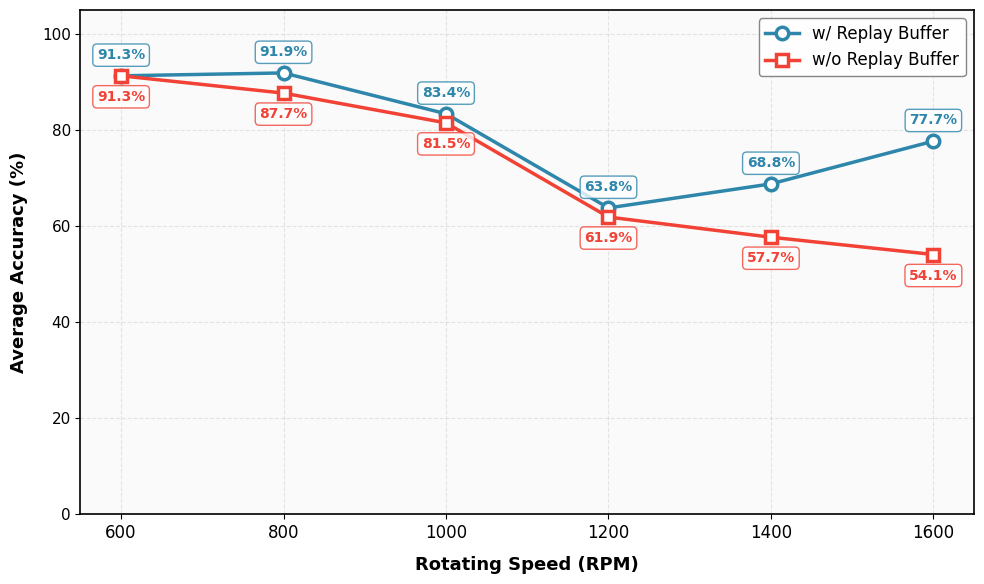

In [16]:
# Figure 생성 (논문용 고품질)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# 컬러 설정 (기존 visualization.py와 동일)
colors = {
    'primary': '#2E86AB',      # 블루 (With Replay Buffer)
    'secondary': '#F24236',    # 레드 (Replay-Free)
}

# 선 그래프 그리기
x_pos = range(len(valid_replay))

line1 = ax.plot(x_pos, valid_replay, 
               marker='o', linewidth=2.5, markersize=9,
               color=colors['primary'], label='w/ Replay Buffer',
               markerfacecolor='white', markeredgewidth=2.5,
               zorder=3)

line2 = ax.plot(x_pos, valid_replay_free,
               marker='s', linewidth=2.5, markersize=9,
               color=colors['secondary'], label='w/o Replay Buffer',
               markerfacecolor='white', markeredgewidth=2.5,
               zorder=3)

# 축 레이블 설정 (논문용)
ax.set_xlabel('Rotating Speed (RPM)', fontweight='bold', fontsize=13, labelpad=10)
ax.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=13, labelpad=10)

# X축 틱 레이블 개선 (수평 배치, 공간 효율적)
x_tick_labels = []
for domain in valid_domains:
    # "600RPM" → "600" 형식으로 변환 (RPM은 X축 레이블에 포함되어 있으므로 생략)
    if 'RPM' in domain:
        rpm_value = domain.replace('RPM', '').strip()
        x_tick_labels.append(rpm_value)  # 숫자만 표시
    else:
        x_tick_labels.append(domain)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_tick_labels, rotation=0, ha='center', fontsize=12, fontweight='normal')

# Y축 설정
ax.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=13, labelpad=10)
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 101, 20))
ax.tick_params(axis='y', labelsize=11)

# 그리드 설정
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, zorder=0)

# 범례 설정 (논문용)
ax.legend(fontsize=12, loc='best', framealpha=0.95, 
         edgecolor='gray', fancybox=True, shadow=False,
         frameon=True, ncol=1)

# 값 표시 (각 점 위/아래에 정확도 표시)
for i, (r_acc, rf_acc) in enumerate(zip(valid_replay, valid_replay_free)):
    # Replay 값 (위쪽)
    ax.annotate(f'{r_acc:.1f}%', (i, r_acc), 
               textcoords="offset points", xytext=(0, 12), ha='center',
               fontsize=10, color=colors['primary'], fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        edgecolor=colors['primary'], alpha=0.8, linewidth=1),
               zorder=4)
    # Replay-Free 값 (아래쪽)
    ax.annotate(f'{rf_acc:.1f}%', (i, rf_acc),
               textcoords="offset points", xytext=(0, -18), ha='center',
               fontsize=10, color=colors['secondary'], fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                        edgecolor=colors['secondary'], alpha=0.8, linewidth=1),
               zorder=4)

# 배경색
ax.set_facecolor('#FAFAFA')

# 전체 레이아웃 조정
plt.tight_layout()

# 저장
if replay_output_dir is None:
    replay_output_dir = Path('.')
else:
    replay_output_dir = Path(replay_output_dir)
    replay_output_dir.mkdir(parents=True, exist_ok=True)

save_path = replay_output_dir / f"{replay_save_name}_{replay_scenario_name}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', pad_inches=0.1)
print(f"\n✅ Replay Comparison Plot 저장 완료: {save_path}")

plt.show()


## 메모리 버퍼 크기별 비교 실험

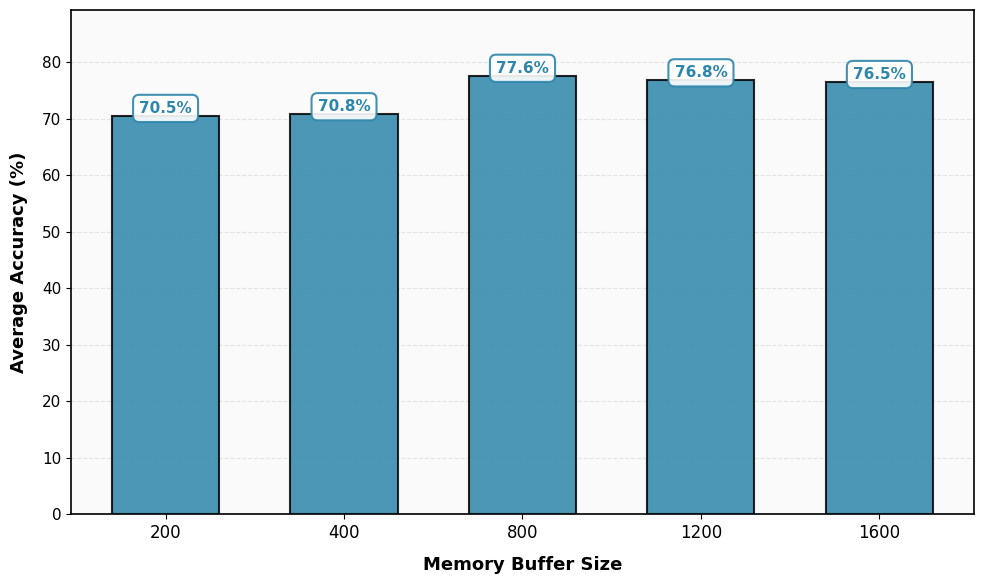

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
memory_sizes = [200, 400, 800, 1200, 1600]
avg_acc = [70.5, 70.8, 77.6, 76.8, 76.5]  # 실제 실험 값으로 교체

# Figure 생성 (논문용 고품질)
fig, ax = plt.subplots(figsize=(10, 6))

# 컬러 설정 (기존 그래프와 통일)
colors = {
    'primary': '#2E86AB',      # 블루
    'secondary': '#F24236',    # 레드
}

# Bar plot 생성
bars = ax.bar(range(len(memory_sizes)), avg_acc, 
              width=0.6, 
              color=colors['primary'], 
              alpha=0.85, 
              edgecolor='black',
              linewidth=1.5,
              zorder=3)

# X축 설정
ax.set_xticks(range(len(memory_sizes)))
ax.set_xticklabels(memory_sizes, fontsize=12, fontweight='normal')
ax.set_xlabel('Memory Buffer Size', fontweight='bold', fontsize=13, labelpad=10)

# Y축 설정
ax.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=13, labelpad=10)
ax.set_ylim(0, max(avg_acc) * 1.15)  # 상단 여유 공간
ax.tick_params(axis='y', labelsize=11)

# 그리드 설정 (기존 그래프와 통일)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, axis='y', zorder=0)
ax.set_axisbelow(True)

# 막대 위에 값 표시 (박스 배경 추가, 기존 그래프 스타일)
for i, (bar, acc) in enumerate(zip(bars, avg_acc)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', 
            fontsize=11, fontweight='bold',
            color=colors['primary'],
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor=colors['primary'], alpha=0.9, linewidth=1.5),
            zorder=4)

# 배경색 (기존 그래프와 통일)
ax.set_facecolor('#FAFAFA')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

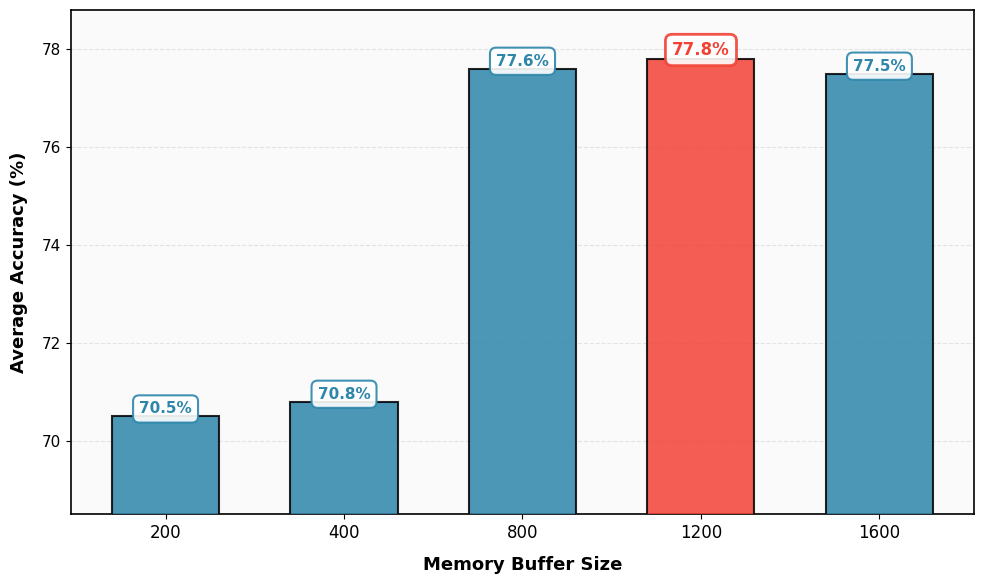

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
memory_sizes = [200, 400, 800, 1200, 1600]
avg_acc = [70.5, 70.8, 77.6, 77.7, 77.5]

# Figure 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 컬러 설정
colors = {
    'primary': '#2E86AB',
    'highlight': '#F24236',  # 최고값 강조용
}

# 최고값 인덱스 찾기
best_idx = np.argmax(avg_acc)

# Bar plot 생성 (최고값만 다른 색)
bar_colors = [colors['highlight'] if i == best_idx else colors['primary'] 
              for i in range(len(avg_acc))]

bars = ax.bar(range(len(memory_sizes)), avg_acc, 
              width=0.6, 
              color=bar_colors, 
              alpha=0.85, 
              edgecolor='black',
              linewidth=1.5,
              zorder=3)

# X축 설정
ax.set_xticks(range(len(memory_sizes)))
ax.set_xticklabels(memory_sizes, fontsize=12)
ax.set_xlabel('Memory Buffer Size', fontweight='bold', fontsize=13, labelpad=10)

# Y축 설정 - 중요! 범위 좁히기
y_min = min(avg_acc) - 2  # 68.5부터 시작
y_max = max(avg_acc) + 1  # 78.6까지
ax.set_ylim(y_min, y_max)
ax.set_ylabel('Average Accuracy (%)', fontweight='bold', fontsize=13, labelpad=10)
ax.tick_params(axis='y', labelsize=11)

# 그리드 설정
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, axis='y', zorder=0)
ax.set_axisbelow(True)

# 막대 위에 값 표시 (최고값 강조)
for i, (bar, acc) in enumerate(zip(bars, avg_acc)):
    height = bar.get_height()
    is_best = (i == best_idx)
    
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', 
            fontsize=12 if is_best else 11,
            fontweight='bold',
            color=colors['highlight'] if is_best else colors['primary'],
            bbox=dict(boxstyle='round,pad=0.4', 
                     facecolor='white', 
                     edgecolor=colors['highlight'] if is_best else colors['primary'],
                     alpha=0.9, 
                     linewidth=2 if is_best else 1.5),
            zorder=4)

# 배경색
ax.set_facecolor('#FAFAFA')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()